# Week6：CNN-2

## 1. 实验内容与流程

### 1.1 实验要求

 1.结合理论课内容，深入理解DenseNet、ResNeXt的结构与FaceNet的工作机制，理解Triplet loss的工作过程。

 2.简要回答实验指导书中的提出的问题。按照指导，补充或改写相应代码，使程序能够运行，并得到相应结果。

 3.提交作业时，请将实验指导书、pics文件夹和数据集文件夹一同打包提交。


### 1.2 知识预备

1.熟悉基本的分类网络，如AlexNet、VGG、ResNet，GoogleNet。

2.理解Residual Block的结构。

3.Triplet loss


### 1.3 实验内容 

1.在基础的ResNet网络结构之上，增加和修改部分结构，设计基础的DenseNet和ResNeXt网络。

2.利用Triplet loss训练一个简单的FaceNet网络，并用knn的方式进行分类预测。

3.本次实验用到的数据集是mnist的部分数据，mnist数据集包括50000张训练图片和10000张测试图片，这次选取其中2000张训练图片，每类200张，

和1000张测试图片，每类100张，作为本次实验的全部数据集。

## 2. DenseNet与ResNeXt

首先回顾一下DenseNet的结构，DenseNet的每一层都都与前面层相连，实现了特征重用。

下图表示一个DenseBlock
![DenseBlock](pics/denseblock.png)


如图所示,在一个DenseBlock中,第i层的输入不仅与i-1层的输出相关,还有所有之前层的输出有关.记作:

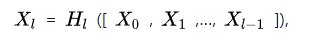

### 2.1 DenseNet网络的搭建

#### Growth_rate

   在一个DenseBlock里面，每个非线性变换H输出的channels数为恒定的Growth_rate，那么第i层的输入的channels数便是k+（i+1）* Growth_rate, k为Input
   
   的channels数，比如，假设我们把Growth_rate设为4，上图中H1的输入的size为8 * 32 * 32，输出为4 * 32 * 32， 则H2的输入的size为12 * 32 * 32，
   
   输出还是4 * 32 * 32，H3、H4以此类推，在实验中，用较小的Growth_rate就能实现较好的效果。

#### Transition Layer

请注意， 在一个DenseBlock里面，feature size并没有发生改变，因为需要对不同层的feature map进行concatenate操作，这需要保持相同的feature size。

因此在相邻的DenseBlock中间使用Down Sampling来增大感受野，即使用Transition Layer来实现，一般的Transition Layer包含BN、Conv和Avg_pool，

同时减少维度，压缩率(compress rate)通常为0.5， 即减少一半的维度。
![DenseNet](pics/densenet.png)

例如，假设block1的输出c * w * h是24 * 32 * 32，那么经过transition之后，block2的输入就是12 * 16 * 16。

#### Bottleneck

为了减少参数和计算量，DenseNet的非线性变换H采用了Bottleneck结构BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3)，1×1的卷积用于降低维度，将channels数降

低至4 * Growth_rate。

### 2.2 定义网络

In [1]:
# Load necessary modules here
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import os


class Bottleneck(nn.Module):
    '''
        the above mentioned bottleneck, including two conv layer, one's kernel size is 1×1, another's is 3×3

        after non-linear operation, concatenate the input to the output
    '''
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        
        # input and output are concatenated here
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    '''
        transition layer is used for down sampling the feature
        
        when compress rate is 0.5, out_planes is a half of in_planes
    '''
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        
        out = self.conv(F.relu(self.bn(x)))
        # use average pooling change the size of feature map here
        out = F.avg_pool2d(out, 2)
        return out 

    
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        '''
        Args:
            block: bottleneck
            nblock: a list, the elements is number of bottleneck in each denseblock
            growth_rate: channel size of bottleneck's output
            reduction: 
        '''
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)
        
        # a DenseBlock and a transition layer
        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        # the channel size is superposed, mutiply by reduction to cut it down here, the reduction is also known as compress rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes
        
        # a DenseBlock and a transition layer
        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        # the channel size is superposed, mutiply by reduction to cut it down here, the reduction is also known as compress rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        # a DenseBlock and a transition layer
        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        # the channel size is superposed, mutiply by reduction to cut it down here, the reduction is also known as compress rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        # only one DenseBlock 
        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        # the last part is a linear layer as a classifier
        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        
        # number of non-linear transformations in one DenseBlock depends on the parameter you set
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def densenet():
    return DenseNet(Bottleneck, [2, 5, 4, 6])

In [2]:
densenet()

DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (trans1): Transition(
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## 作业1
上面的定义的DenseNet为多少层DenseNet（只计算卷积层与全连接层）？请定义一个卷积层总数为52层的DenseNet。

答：共39层。

conv1: 1  
dense1: 2 * 2 = 4  
trans1: 1  
dense2: 2 * 5 = 10  
trans2: 1  
dense3: 2 * 4 = 8  
trans3: 1  
dense4: 2 * 6 = 12  
linear: 1  

In [2]:
def densenet52():
    return DenseNet(Bottleneck, [6, 6, 6, 6])

In [4]:
densenet52()

DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

### 2.3 训练与测试

In [15]:
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable


def train(epoch, model, lossFunction, optimizer, device, trainloader):
    """train model using loss_fn and optimizer. When this function is called, model trains for one epoch.
    Args:
        train_loader: train data
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
        optimizer: optimize the loss function
        get_grad: True, False
    output:
        total_loss: loss
        average_grad2: average grad for hidden 2 in this epoch
        average_grad3: average grad for hidden 3 in this epoch
    """
    print('\nEpoch: %d' % epoch)
    model.train()     # enter train mode
    train_loss = 0    # accumulate every batch loss in a epoch
    correct = 0       # count when model' prediction is correct i train set
    total = 0         # total number of prediction in train set
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device) # load data to gpu device
        inputs, targets = Variable(inputs), Variable(targets)
        optimizer.zero_grad()            # clear gradients of all optimized torch.Tensors'
        outputs = model(inputs)          # forward propagation return the value of softmax function
        loss = lossFunction(outputs, targets) #compute loss
        loss.backward()                  # compute gradient of loss over parameters 
        optimizer.step()                 # update parameters with gradient descent 

        train_loss += loss.item()        # accumulate every batch loss in a epoch
        _, predicted = outputs.max(1)    # make prediction according to the outputs
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item() # count how many predictions is correct
        
        if (batch_idx+1) % 100 == 0:
            # print loss and acc
            print( 'Train loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print( 'Train loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    
def test(model, lossFunction, optimizer, device, testloader):
    """
    test model's prediction performance on loader.  
    When thid function is called, model is evaluated.
    Args:
        loader: data for evaluation
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
    output:
        total_loss
        accuracy
    """
    global best_acc
    model.eval() #enter test mode
    test_loss = 0 # accumulate every batch loss in a epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = lossFunction(outputs, targets) #compute loss

            test_loss += loss.item() # accumulate every batch loss in a epoch
            _, predicted = outputs.max(1) # make prediction according to the outputs
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item() # count how many predictions is correct
        # print loss and acc
        print('Test Loss: %.3f  | Test Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

        
def data_loader():
    # define method of preprocessing data for evaluating
    transform_train = transforms.Compose([
        transforms.Resize(32),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Normalize a tensor image with mean and standard variance
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        # Normalize a tensor image with mean and standard variance
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    # prepare dataset by ImageFolder, data should be classified by directory
    trainset = torchvision.datasets.ImageFolder(root='./mnist/train', transform=transform_train)

    testset = torchvision.datasets.ImageFolder(root='./mnist/test', transform=transform_test)

    # Data loader. 

    # Combines a dataset and a sampler, 

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
    return trainloader, testloader

def run(model, num_epochs):
    
    # load model into GPU device
    device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    if device == 'cuda:2':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True

    # define the loss function and optimizer

    lossFunction = nn.CrossEntropyLoss()
    lr = 0.01
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    trainloader, testloader = data_loader()
    for epoch in range(num_epochs):
        train(epoch, model, lossFunction, optimizer, device, trainloader)
        test(model, lossFunction, optimizer, device, testloader)
        if (epoch + 1) % 50 == 0 :
            lr = lr / 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

用你自己定义的DenseNet进行测试

In [6]:
# start training and testing
model = densenet52()
# num_epochs is adjustable
run(model, num_epochs=20)


Epoch: 0
Train loss: 2.067 | Train Acc: 32.800% (656/2000)
Test Loss: 1.746  | Test Acc: 31.300% (313/1000)

Epoch: 1
Train loss: 1.310 | Train Acc: 60.800% (1216/2000)
Test Loss: 1.249  | Test Acc: 50.300% (503/1000)

Epoch: 2
Train loss: 0.721 | Train Acc: 79.350% (1587/2000)
Test Loss: 0.607  | Test Acc: 76.600% (766/1000)

Epoch: 3
Train loss: 0.516 | Train Acc: 82.750% (1655/2000)
Test Loss: 1.334  | Test Acc: 66.300% (663/1000)

Epoch: 4
Train loss: 0.471 | Train Acc: 83.950% (1679/2000)
Test Loss: 0.923  | Test Acc: 69.200% (692/1000)

Epoch: 5
Train loss: 0.389 | Train Acc: 87.450% (1749/2000)
Test Loss: 0.382  | Test Acc: 88.800% (888/1000)

Epoch: 6
Train loss: 0.307 | Train Acc: 90.500% (1810/2000)
Test Loss: 0.408  | Test Acc: 87.600% (876/1000)

Epoch: 7
Train loss: 0.314 | Train Acc: 89.950% (1799/2000)
Test Loss: 0.502  | Test Acc: 81.500% (815/1000)

Epoch: 8
Train loss: 0.233 | Train Acc: 93.150% (1863/2000)
Test Loss: 3.784  | Test Acc: 25.300% (253/1000)

Epoch: 9
T

### 2.4 ResNeXt网络的搭建

###### cardinality

cardinality, 指的是repeat layer的个数，下图右边cardinality为32。左图是ResNet的基本结构，输入channel size为64，右图是ResNeXt的基本结构，

输入channel size是128，但两者具有相近的参数量。
![cardinality](pics/cardinality.png)

###### ResNeXt Block

有三种等价的ResNeXt Block，如下图，a是ResNeXt基本单元，如果把输出那里的1x1合并到一起，得到等价网络b拥有和Inception-ResNet相似的结构，

而进一步把输入的1x1也合并到一起，得到等价网络c则和通道分组卷积的网络有相似的结构。
![ResNeXtBlock](pics/ResNeXtBlock.png)

###### ResNeXt网络结构

下图表示ResNeXt-50(32x4d)的网络结构，卷积层和全连接层总数为50层，32表示的是cardinality,4d表示每一个repeat layer的channel数为4，所以整个block的通道数是32x4=128.
![ResNeXt](pics/ResNeXt.png)

In [4]:
class Block(nn.Module):
    '''
        Grouped convolution block(c).
        
    '''
    expansion = 2

    def __init__(self, in_planes, cardinality=32, bottleneck_width=4, stride=1):
        '''
            in_planes: channel size of input
            cardinality: number of groups
            bottleneck_width: channel size of each group
        '''
        super(Block, self).__init__()
        group_width = cardinality * bottleneck_width
        self.conv1 = nn.Conv2d(in_planes, group_width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(group_width)
        # divide into 32 groups which 32 is cardinality
        self.conv2 = nn.Conv2d(group_width, group_width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(group_width)
        self.conv3 = nn.Conv2d(group_width, self.expansion*group_width, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*group_width)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*group_width:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*group_width, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*group_width)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [5]:
class ResNeXt(nn.Module):
    def __init__(self, num_blocks, cardinality, bottleneck_width, num_classes=10):
        '''
            num_blocks: list type, channel size of input
            cardinality: number of groups
            bottleneck_width: channel size of each group
        '''
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # size 32x32
        self.layer1 = self._make_layer(num_blocks[0], 1)
        # size 32x32
        self.layer2 = self._make_layer(num_blocks[1], 2)
        # size 16x16
        self.layer3 = self._make_layer(num_blocks[2], 2)
        # size 8x8
        self.linear = nn.Linear(cardinality*bottleneck_width*8, num_classes)

    def _make_layer(self, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_planes, self.cardinality, self.bottleneck_width, stride))
            self.in_planes = Block.expansion * self.cardinality * self.bottleneck_width
        # Increase bottleneck_width by 2 after each stage.
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


## 作业2：
定义一个ResNeXt-32(16x8d)（补全下面一行代码），仿照DenseNet的方式训练和测试这个网络得出前20个epoch结果，分析这个结果好或坏的原因

In [10]:
ResNeXt32_16x8d = ResNeXt([2, 3, 4], 16, 8)
run(ResNeXt32_16x8d, num_epochs=20)


Epoch: 0
Train loss: 2.099 | Train Acc: 26.950% (539/2000)
Test Loss: 1.978  | Test Acc: 32.700% (327/1000)

Epoch: 1
Train loss: 1.120 | Train Acc: 64.250% (1285/2000)
Test Loss: 1.520  | Test Acc: 47.100% (471/1000)

Epoch: 2
Train loss: 0.651 | Train Acc: 78.050% (1561/2000)
Test Loss: 0.693  | Test Acc: 79.500% (795/1000)

Epoch: 3
Train loss: 0.465 | Train Acc: 84.000% (1680/2000)
Test Loss: 0.381  | Test Acc: 88.000% (880/1000)

Epoch: 4
Train loss: 0.355 | Train Acc: 87.950% (1759/2000)
Test Loss: 0.726  | Test Acc: 76.800% (768/1000)

Epoch: 5
Train loss: 0.311 | Train Acc: 90.550% (1811/2000)
Test Loss: 0.788  | Test Acc: 76.600% (766/1000)

Epoch: 6
Train loss: 0.261 | Train Acc: 92.000% (1840/2000)
Test Loss: 0.482  | Test Acc: 83.900% (839/1000)

Epoch: 7
Train loss: 0.221 | Train Acc: 92.800% (1856/2000)
Test Loss: 0.208  | Test Acc: 93.800% (938/1000)

Epoch: 8
Train loss: 0.217 | Train Acc: 93.250% (1865/2000)
Test Loss: 0.197  | Test Acc: 93.600% (936/1000)

Epoch: 9
T

答：

使用ResNeXt的预测结果比DenseNet要好一点，产生这种结果可能是因为ResNeXt的多分支模块化结构，相比于DenseNet的每两层之间传递梯度的结构，在同样的超参数环境下，能得到更好的预测模型。

其次，可能是训练集和测试集在ResNeXt上效果较好，而在DenseNet上效果较差。

## 3.FaceNet

有关FaceNet与triplet loss的理论知识请同学们复习理论课有关章节。在这里，我们将用triplet loss训练一个resnet18网络，并用这个网络在mnist数据集上进行KNN分类，具体的，resnet18相当于一个特征提取器，用所有的训练集图片的特征拟合一个KNN分类器，利用这个KNN分类进行预测. 在3.1小节，将给出triplet loss的实现. 3.2小节将实现一个适用于triplet loss训练的resnet18网络. 3.3小节将实现随机选取triplet的dataset, 3.4、3.5小节将分别实现resnet18的训练与测试函数.

###### embedding size

facenet的作用是将图像嵌入一个d维的空间，在这个d维空间里，同一类图像的特征之间相隔的近，不同类图像的特征之间相隔的远，这个d我们称之为embedding size

### 3.1 triplet loss

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import os
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable,Function

class PairwiseDistance(Function):
    '''
        compute distance of the embedding features, p is norm, when p is 2, then return L2-norm distance
    '''
    def __init__(self, p):
        super(PairwiseDistance, self).__init__()
        self.norm = p

    def forward(self, x1, x2):
        eps = 1e-6  # in case of zeros
        diff = torch.abs(x1 - x2)     # subtraction
        out = torch.pow(diff, self.norm).sum(dim=1) # square
        return torch.pow(out + eps, 1. / self.norm) # L-p norm


class TripletLoss(Function):
    '''
       Triplet loss function.
       loss = max(diatance(a,p) - distance(a,n) + margin, 0)
       forward method:
           args:
                anchor, positive, negative
           return:
                triplet loss
    '''
    def __init__(self, margin, num_classes=10):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.num_classes = num_classes
        self.pdist = PairwiseDistance(2) # to calculate distance

    def forward(self, anchor, positive, negative):
        d_p = self.pdist.forward(anchor, positive) # distance of anchor and positive
        d_n = self.pdist.forward(anchor, negative) # distance of anchor and negative

        dist_hinge = torch.clamp(self.margin + d_p - d_n, min=0.0) # ensure loss is no less than zero
        loss = torch.mean(dist_hinge)
        return loss


### 3.2 resnet-18 for triplet loss

In [7]:
class BasicBlock(nn.Module):
    '''
        resnet basic block.
        one block includes two conv layer and one residual
    '''
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):

        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

    
class ResNetTriplet(nn.Module):
    def __init__(self, block, num_blocks, embedding_size=256, num_classes=10):
        super(ResNetTriplet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # feature map size 32x32
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        # feature map size 32x32
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        # feature map size 16x16
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # feature map size 8x8
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # feature map size 4x4
        # as we use resnet basic block, the expansion is 1
        self.linear = nn.Linear(512*block.expansion, embedding_size)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def l2_norm(self,input):
        input_size = input.size()
        buffer = torch.pow(input, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)
        _output = torch.div(input, norm.view(-1, 1).expand_as(input))
        output = _output.view(input_size)
        return output

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        # normalize the features, then we set margin easily
        self.features = self.l2_norm(out)
        # multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        alpha = 10
        self.features = self.features * alpha
        # here we get the 256-d features, next we use those features to make prediction
        return self.features

    
def ResNet18(embedding_size=256, num_classes=10):
    
    return ResNetTriplet(BasicBlock, [2,2,2,2], embedding_size, num_classes)


### 3.3 triplet dataloader

## 作业3
仔细阅读下面代码，对pic_classes的作用进行思考，回答下面问题：下面选取triplet的方式是随机选取，若要改为选择指定类别选取，怎么修改？请写出修改后的两行代码。

In [8]:
import numpy as np
import pandas as pd

def test_modify():
    def generate_triplets(df, num_triplets, pos_class, neg_class):
        def make_dictionary_for_pic_class(df):
            pic_classes = dict()
            for idx, label in enumerate(df['class']):
                if label not in pic_classes:
                    pic_classes[label] = []
                pic_classes[label].append(df.iloc[idx, 0])
            return pic_classes
        
        triplets    = []
        pic_classes = make_dictionary_for_pic_class(df)
        
        for _ in range(num_triplets):
            pos_name = df.loc[df['class'] == pos_class, 'name'].values[0] # get positive class's name
            neg_name = df.loc[df['class'] == neg_class, 'name'].values[0] # get negative class's name

            if len(pic_classes[pos_class]) == 2:
                ianc, ipos = np.random.choice(2, size = 2, replace = False)
            else:
                ianc = np.random.randint(0, len(pic_classes[pos_class]))  # random choose anchor
                ipos = np.random.randint(0, len(pic_classes[pos_class]))  # random choose positive
                while ianc == ipos:
                    ipos = np.random.randint(0, len(pic_classes[pos_class]))
            ineg = np.random.randint(0, len(pic_classes[neg_class]))      # random choose negative

            triplets.append([pic_classes[pos_class][ianc], pic_classes[pos_class][ipos], pic_classes[neg_class][ineg],
                 pos_class, neg_class, pos_name, neg_name])
        return triplets
    df = pd.read_csv('./mnist/train.csv')
    print(generate_triplets(df, 5, 8, 0))

test_modify()

[['mnist_train_17302', 'mnist_train_41801', 'mnist_train_4145', 8, 0, 8, 0], ['mnist_train_56600', 'mnist_train_53952', 'mnist_train_52313', 8, 0, 8, 0], ['mnist_train_41801', 'mnist_train_3354', 'mnist_train_51464', 8, 0, 8, 0], ['mnist_train_37488', 'mnist_train_18156', 'mnist_train_27628', 8, 0, 8, 0], ['mnist_train_5534', 'mnist_train_38606', 'mnist_train_5646', 8, 0, 8, 0]]


答：如上面的代码，将生成neg_class和pos_class的代码删掉，然后在函数参数中加入两个参数，指定两者的类型。

In [9]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset


class TripletFaceDataset(Dataset):

    def __init__(self, root_dir, csv_name, num_triplets, transform = None):
        '''
        randomly select triplet,which means anchor,positive and negative are all selected randomly.
        args:
            root_dir : dir of data set
            csv_name : dir of train.csv
            num_triplets: total number of triplets
        '''
        
        self.root_dir          = root_dir
        self.df                = pd.read_csv(csv_name)
        self.num_triplets      = num_triplets
        self.transform         = transform
        self.training_triplets = self.generate_triplets(self.df, self.num_triplets)
    @staticmethod
    def generate_triplets(df, num_triplets):
        
        def make_dictionary_for_pic_class(df):

            '''
                make csv to the format that we want
              - pic_classes = {'class0': [class0_id0, ...], 'class1': [class1_id0, ...], ...}
            '''
            pic_classes = dict()
            for idx, label in enumerate(df['class']):
                if label not in pic_classes:
                    pic_classes[label] = []
                pic_classes[label].append(df.iloc[idx, 0])
            return pic_classes
        
        triplets    = []
        classes     = df['class'].unique()
        pic_classes = make_dictionary_for_pic_class(df)
        
        for _ in range(num_triplets):

            '''
              - randomly choose anchor, positive and negative images for triplet loss
              - anchor and positive images in pos_class
              - negative image in neg_class
              - at least, two images needed for anchor and positive images in pos_class
              - negative image should have different class as anchor and positive images by definition
            '''
        
            pos_class = np.random.choice(classes)     # random choose positive class
            neg_class = np.random.choice(classes)     # random choose negative class
            while len(pic_classes[pos_class]) < 2:
                pos_class = np.random.choice(classes)
            while pos_class == neg_class:
                neg_class = np.random.choice(classes)

            pos_name = df.loc[df['class'] == pos_class, 'name'].values[0] # get positive class's name
            neg_name = df.loc[df['class'] == neg_class, 'name'].values[0] # get negative class's name

            if len(pic_classes[pos_class]) == 2:
                ianc, ipos = np.random.choice(2, size = 2, replace = False)
            else:
                ianc = np.random.randint(0, len(pic_classes[pos_class]))  # random choose anchor
                ipos = np.random.randint(0, len(pic_classes[pos_class]))  # random choose positive
                while ianc == ipos:
                    ipos = np.random.randint(0, len(pic_classes[pos_class]))
            ineg = np.random.randint(0, len(pic_classes[neg_class]))      # random choose negative

            triplets.append([pic_classes[pos_class][ianc], pic_classes[pos_class][ipos], pic_classes[neg_class][ineg],
                 pos_class, neg_class, pos_name, neg_name])
        
        return triplets
    
    
    def __getitem__(self, idx):
        
        anc_id, pos_id, neg_id, pos_class, neg_class, pos_name, neg_name = self.training_triplets[idx]
        
        anc_img   = os.path.join(self.root_dir, str(pos_name), str(anc_id) + '.png') # join the path of anchor
        pos_img   = os.path.join(self.root_dir, str(pos_name), str(pos_id) + '.png') # join the path of positive
        neg_img   = os.path.join(self.root_dir, str(neg_name), str(neg_id) + '.png') # join the path of nagetive
        
        anc_img = Image.open(anc_img).convert('RGB') # open the anchor image
        pos_img = Image.open(pos_img).convert('RGB') # open the positive image
        neg_img = Image.open(neg_img).convert('RGB') # open the negative image

        pos_class = torch.from_numpy(np.array([pos_class]).astype('long'))  # make label transform the type we want
        neg_class = torch.from_numpy(np.array([neg_class]).astype('long'))  # make label transform the type we want

        data = [anc_img, pos_img,neg_img]
        label = [pos_class, pos_class, neg_class]

        if self.transform:
            data = [self.transform(img)  # preprocessing the image
                    for img in data]
            
        return data, label
    
    def __len__(self):
        
        return len(self.training_triplets)



### 3.4 train function for triplet loss

In [10]:
import torchvision.transforms as transforms

def train_facenet(epoch, model, optimizer, margin, num_triplets):
    model.train()
    # preprocessing function for image
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=np.array([0.4914, 0.4822, 0.4465]),
            std=np.array([0.2023, 0.1994, 0.2010])),
    ])
    
    # get dataset of triplet
    
    # num_triplet is adjustable
    train_set = TripletFaceDataset(root_dir     = './mnist/train',
                                   csv_name     = './mnist/train.csv',
                                   num_triplets = num_triplets,
                                   transform    = transform)

    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size  = 16,
                                               shuffle     = True)


    total_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        # load data to gpu
        data[0], target[0] = data[0].cuda(2), target[0].cuda(2)  # anchor to cuda
        data[1], target[1] = data[1].cuda(2), target[1].cuda(2)  # positive to cuda
        data[2], target[2] = data[2].cuda(2), target[2].cuda(2)  # negative to cuda

        data[0], target[0] = Variable(data[0]), Variable(target[0]) # anchor
        data[1], target[1] = Variable(data[1]), Variable(target[1]) # positive
        data[2], target[2] = Variable(data[2]), Variable(target[2]) # negative
        # zero setting the grad
        optimizer.zero_grad()
        # forward
        anchor   = model.forward(data[0])
        positive = model.forward(data[1])
        negative = model.forward(data[2])
        
        # margin is adjustable
        loss = TripletLoss(margin=margin, num_classes=10).forward(anchor, positive, negative) # get triplet loss
        total_loss += loss.item()
        # back-propagating
        loss.backward()
        optimizer.step()

    context = 'Train Epoch: {} [{}/{}], Average loss: {:.4f}'.format(
        epoch, len(train_loader.dataset), len(train_loader.dataset), total_loss / len(train_loader))
    print(context)

### 3.5 test function for triplet loss

关于如何测试的问题，由于triplet loss训练的resnet18网络没有分类器，这个网络的最后一层的输出是一个维度为embedding_size的向量，我们把它当作由模型提取出的特征，所以利用这个特征来做测试。首先保存下训练集上所有图片的特征和标签，用sklearn库的KNeighborsClassifier()拟合成一个KNN分类器，这里的K表示领域的个数，K是一个可调节的参数，在测试集上做验证时，提取图片的特征用KNN分类器做预测即可。

## 作业4：
仔细阅读下面代码，回答问题：下面的预测方法为KNN预测，若要改为中心点预测的方式，即找出每个类别的离均值点最近的图片做最近邻预测，请简述找出中心点的方法，无需写代码。

答： 首先将训练集中的数据按标签类别分类，然后将同一类数据归在一起，并计算每一类数据的均值点。在一类数据中，根据该均值点选择最近的一张或多张图片，然后每个类别都可以得到相应的代表图片。将测试集的位置与这些类别代表图片的位置对比，选择最近的图片，其标签就是预测的标签。

In [11]:
from sklearn import neighbors

def KNN_classifier(model, epoch, n_neighbors):
    '''
        use all train set data to make KNN classifier
    '''
    model.eval()
    # preprocessing function for image
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=np.array([0.485, 0.456, 0.406]),
            std=np.array([0.229, 0.224, 0.225])),
    ])
    # prepare dataset by ImageFolder, data should be classified by directory
    train_set = torchvision.datasets.ImageFolder(root='./mnist/train', transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)

    features, labels =[], [] # store features and labels
    for i, (data, target) in enumerate(train_loader):
        #  load data to gpu
        data, target = data.cuda(2), target.cuda(2)
        data, target = Variable(data), Variable(target)
        # forward
        output = model(data)
        # get features and labels to make knn classifier
        features.extend(output.data.cpu().numpy())
        labels.extend(target.data.cpu().numpy())
        
    # n_neighbor is adjustable
    clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(features, labels)

    return clf



def test_facenet(epoch, model, clf, test = True):
    model.eval()
    # preprocessing function for image
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=np.array([0.485, 0.456, 0.406]),
            std=np.array([0.229, 0.224, 0.225])),
    ])
    # prepare dataset by ImageFolder, data should be classified by directory
    test_set = torchvision.datasets.ImageFolder(root = './mnist/test' if test else './mnist/train', transform = transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = True)

    correct, total = 0, 0

    for i, (data, target) in enumerate(test_loader):
        # load data to gpu
        data, target = data.cuda(2), target.cuda(2)
        data, target = Variable(data), Variable(target)
        # forward
        output = model.forward(data)
        # predict by knn classifier
        predicted = clf.predict(output.data.cpu().numpy())
        
        correct += (torch.tensor(predicted) == target.data.cpu()).sum()
        total += target.size(0)

    context = 'Accuracy of model in ' + ('test' if test else 'train') + \
              ' set is {}/{}({:.2f}%)'.format(correct, total, 100. * float( correct) / float(total))
    print(context)


### 3.6训练与测试

In [12]:
def run_facenet():
    # hyper parameter
    lr = 0.01
    margin = 2.0
    num_triplets = 1000
    n_neighbors = 5
    embedding_size = 128
    num_epochs=1
    
    # embedding_size is adjustable
    model = ResNet18(embedding_size, 10)
    
    # load model into GPU device
    device = torch.device('cuda:0')
    model = model.to(device)
    if device == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    
    # define the optimizer, lr、momentum、weight_decay is adjustable
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    
    print('start training')
    for epoch in range(num_epochs):  
        train_facenet(epoch, model, optimizer, margin, num_triplets) # train resnet18 with triplet loss
        clf = KNN_classifier(model, epoch, n_neighbors)     # get knn classifier
        test_facenet(epoch, model, clf, False)  # validate train set
        test_facenet(epoch, model, clf, True)   # validate test set
        if (epoch + 1) % 4 == 0 :
            lr = lr / 3
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        

In [10]:
run_facenet()

start training
Train Epoch: 0 [1000/1000], Average loss: 1.0609
Accuracy of model in train set is 1634/2000(81.70%)
Accuracy of model in test set is 764/1000(76.40%)


## 作业5（占20%）：
训练一个较好的resnet18网络，收集在测试集上所有预测错误的样本图片（1000张测试集图片，分错不应超过30张，5%）。并在训练集上找出离这个样本最近的同类样本和错类样本的图片，**并作出简要分析**（15%）。例如，对于一个样本sample，正确类别为A，模型将其错分为B，分别找出训练集中A类样本和B类样本中离sample最近的样本图片（注意是图片！**注意一定要保存在pics文件夹或者自定义文件夹一同提交，否则TA看不到，将图片在下面展示出来**）。

答：

通过修改超参数，我们得到一个对于测试集准确率超过97%的模型，然后根据这个模型来再次预测测试集的数据，讲预测错误的图片显示出来。图片显示见本节最后。

可以发现，预测错误的原因大都是测试集图片过于潦草，笔画与笔画之间几乎接近重合。甚至，有些样本让人来分辨也难以区分。其次，训练集上存在部分与该样本极其相近的图片，但是其标签是别的分类，因此会导致测试集预测错误的概率大大增长。



In [19]:
import pandas
import matplotlib.pyplot as plt
    
def run_facenet18():
    # hyper parameter
    lr = 0.01
    margin = 0.7
    num_triplets = 4000
    n_neighbors = 10
    embedding_size = 256
    num_epochs=10
    
    # embedding_size is adjustable
    model = ResNet18(embedding_size, 10)
    
    # load model into GPU device
    device = torch.device('cuda:2')
    model = model.to(device)
    if device == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    
    # define the optimizer, lr、momentum、weight_decay is adjustable
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    
    print('start training')
    for epoch in range(num_epochs):  
        train_facenet(epoch, model, optimizer, margin, num_triplets) # train resnet18 with triplet loss
        clf = KNN_classifier(model, epoch, n_neighbors)     # get knn classifier
        test_facenet(epoch, model, clf, False)  # validate train set
        test_facenet(epoch, model, clf, True)   # validate test set
        if (epoch + 1) % 4 == 0 :
            lr = lr / 3
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
    return model

In [21]:
torch.cuda.set_device(2)

model = run_facenet18()

start training
Train Epoch: 0 [4000/4000], Average loss: 0.1869
Accuracy of model in train set is 1889/2000(94.45%)
Accuracy of model in test set is 942/1000(94.20%)
Train Epoch: 1 [4000/4000], Average loss: 0.0472
Accuracy of model in train set is 1916/2000(95.80%)
Accuracy of model in test set is 947/1000(94.70%)
Train Epoch: 2 [4000/4000], Average loss: 0.0407
Accuracy of model in train set is 1950/2000(97.50%)
Accuracy of model in test set is 971/1000(97.10%)
Train Epoch: 3 [4000/4000], Average loss: 0.0246
Accuracy of model in train set is 1950/2000(97.50%)
Accuracy of model in test set is 976/1000(97.60%)
Train Epoch: 4 [4000/4000], Average loss: 0.0101
Accuracy of model in train set is 1972/2000(98.60%)
Accuracy of model in test set is 979/1000(97.90%)
Train Epoch: 5 [4000/4000], Average loss: 0.0101
Accuracy of model in train set is 1976/2000(98.80%)
Accuracy of model in test set is 980/1000(98.00%)
Train Epoch: 6 [4000/4000], Average loss: 0.0060
Accuracy of model in train set

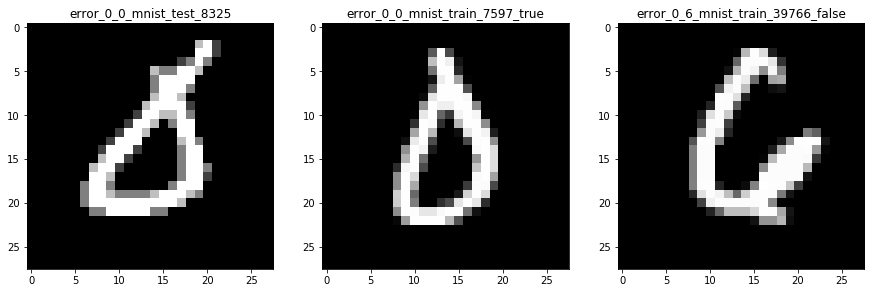

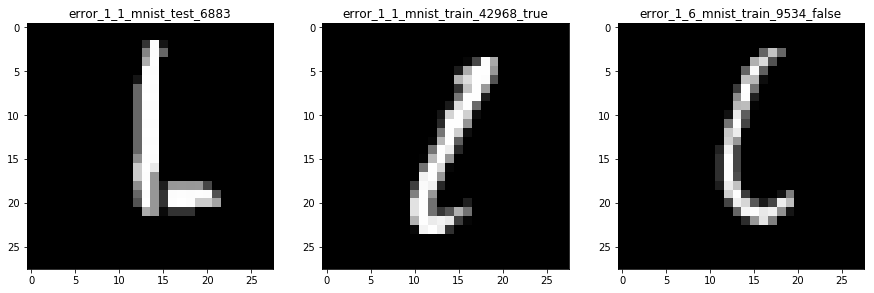

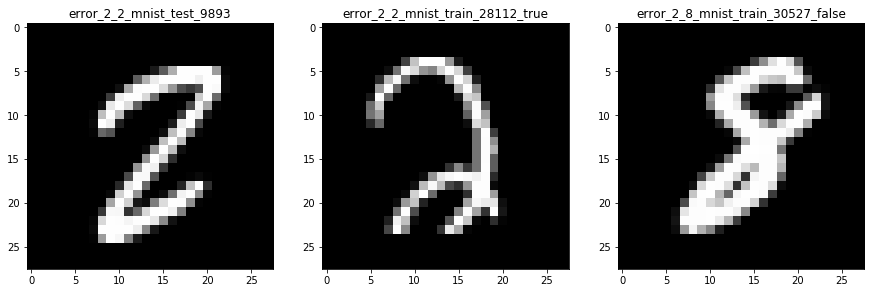

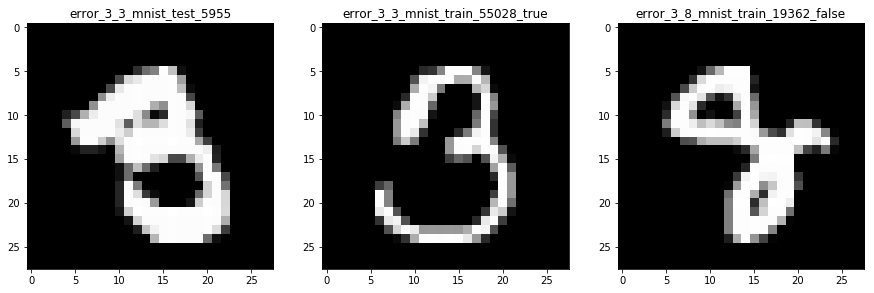

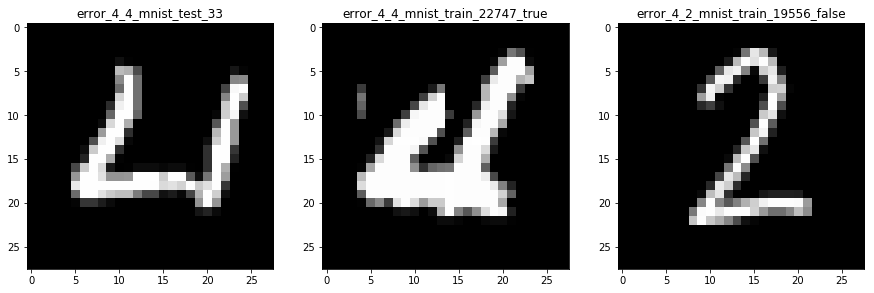

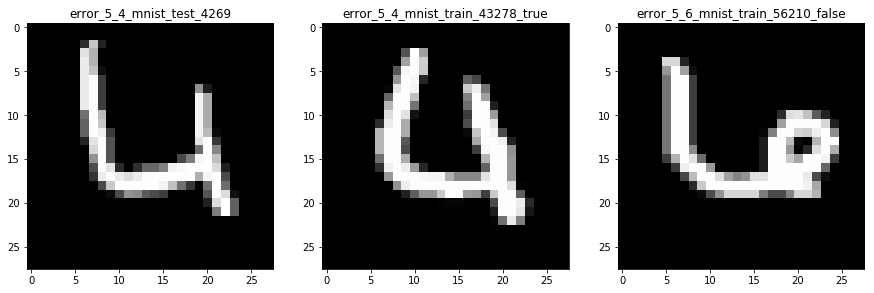

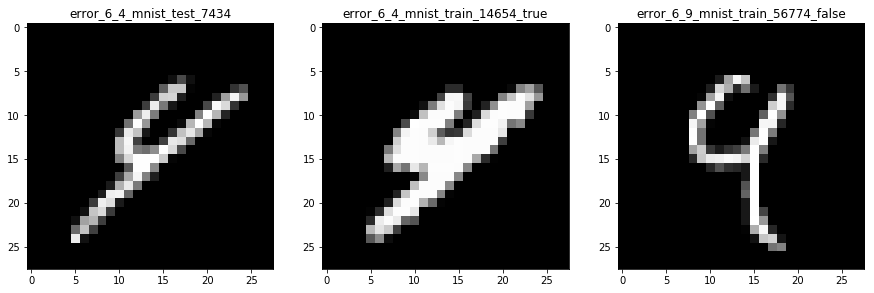

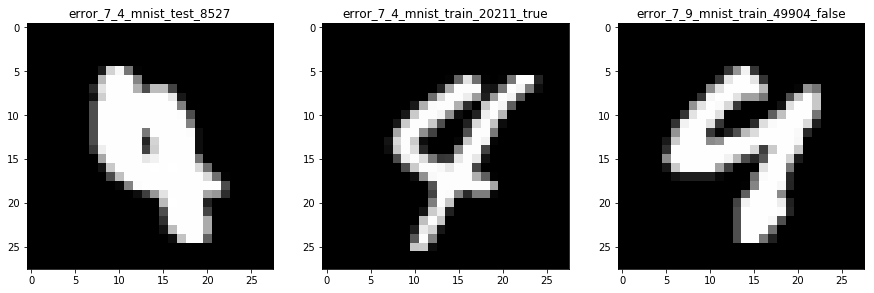

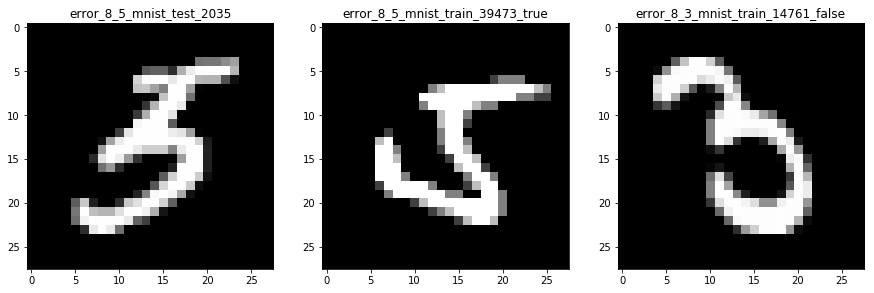

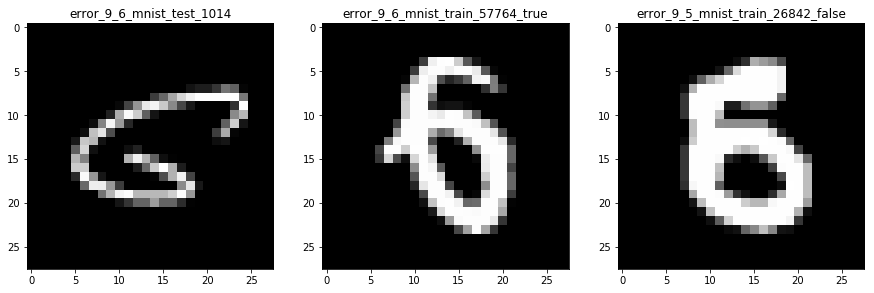

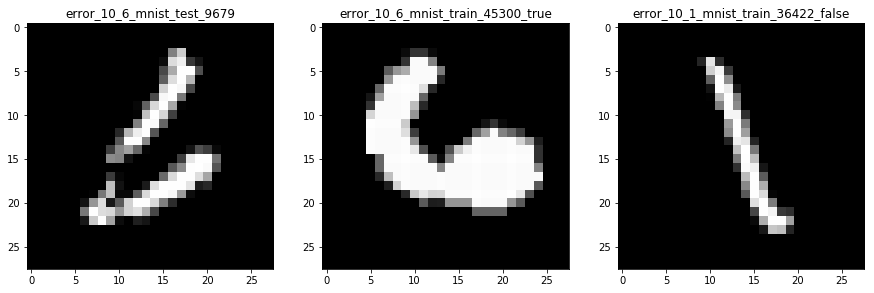

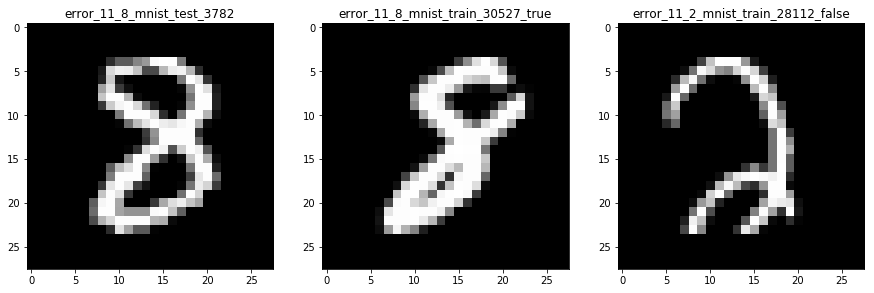

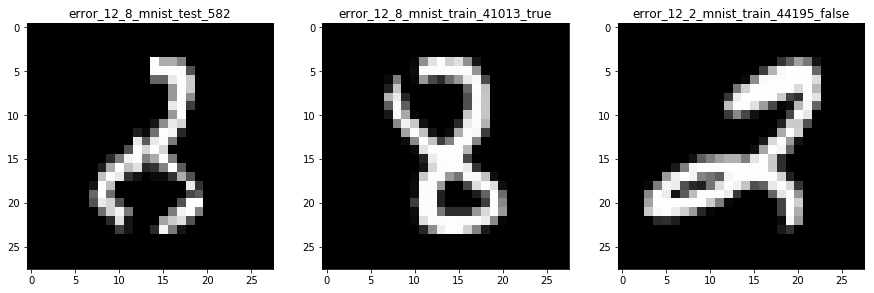

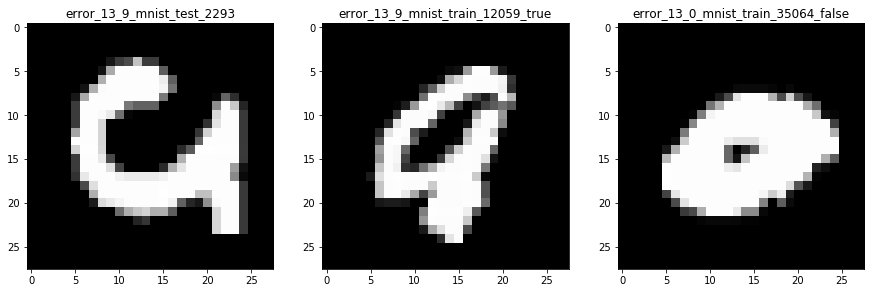

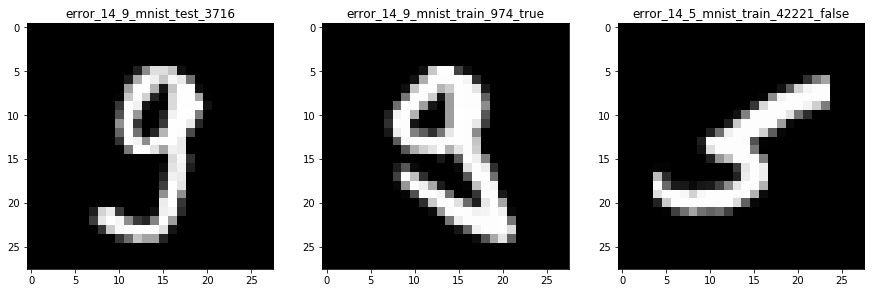

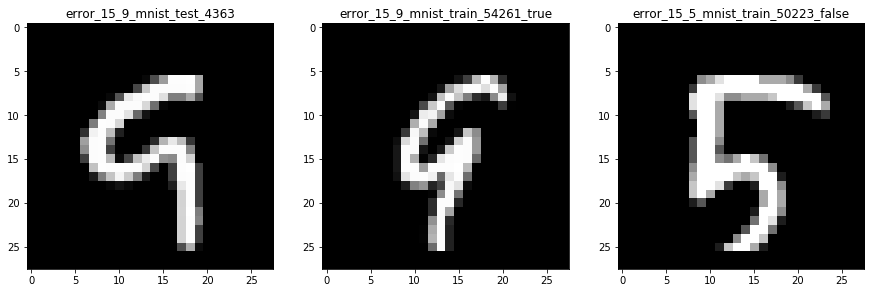

In [34]:
def show_sample(model, n_neighbors):
    frame_train = pandas.read_csv('./mnist/train.csv')
    frame_test = pandas.read_csv('./mnist/test.csv')

    model.eval()
    
    # preprocessing function for image
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=np.array([0.485, 0.456, 0.406]),
            std=np.array([0.229, 0.224, 0.225])),
    ])
    clf = KNN_classifier(model, 0, n_neighbors)
    
    train_set = torchvision.datasets.ImageFolder(root='./mnist/train', transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)

    test_set = torchvision.datasets.ImageFolder(root='./mnist/test', transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
    
    features =[]
    for i, (data, target) in enumerate(train_loader):
        data, target = data.cuda(2), target.cuda(2)
        data, target = Variable(data), Variable(target)
        output = model(data)
        features.extend(output.data.cpu().numpy())
    
    tlen = len(features) // 10;
    dis = PairwiseDistance(2)
    
    index = 0
    
    for i, (data, target) in enumerate(test_loader):
        data, target = data.cuda(2), target.cuda(2)
        data, target = Variable(data), Variable(target)
        output = model.forward(data)
        predicted = clf.predict(output.data.cpu().numpy())
        for j in range(len(output.data.cpu().numpy())):
            if predicted[j] != target[j]:
                class_t = target[j]
                class_f = predicted[j]
                dis_t_min = None
                dis_f_min = None
                for k in range(tlen):
                    dis_t = dis.forward(torch.from_numpy(features[class_t * tlen + k]).unsqueeze(0), output.data.cpu()[j].unsqueeze(0))
                    if dis_t_min is None or dis_t_min > dis_t:
                        dis_t_min = dis_t
                        dis_t_i = class_t * tlen + k
                for k in range(tlen):
                    dis_f = dis.forward(torch.from_numpy(features[class_f * tlen + k]).unsqueeze(0), output.data.cpu()[j].unsqueeze(0))
                    if dis_f_min is None or dis_f_min > dis_f:
                        dis_f_min = dis_f
                        dis_f_i = class_f * tlen + k
                # 错误图片
                image_path = os.path.join('./mnist/test', str(frame_test['name'][i * 32 + j]), str(frame_test['id'][i * 32 + j]) + '.png')
                image = Image.open(image_path).convert('RGB')
                image.save('./output/error_'+str(index)+'_'+str(frame_test['name'][i * 32 + j])+'_'+str(frame_test['id'][i * 32 + j])+'.png', 'png')
                # 与目标同类型的
                image_path = os.path.join('./mnist/train', str(frame_train['name'][dis_t_i]), str(frame_train['id'][dis_t_i]) + '.png')
                image_t = Image.open(image_path).convert('RGB')
                image_t.save('./output/error_'+str(index)+'_'+str(frame_train['name'][dis_t_i])+'_'+str(frame_train['id'][dis_t_i])+'_t.png', 'png')
                # 与预测同类型的
                image_path = os.path.join('./mnist/train', str(frame_train['name'][dis_f_i]), str(frame_train['id'][dis_f_i]) + '.png')
                image_f = Image.open(image_path).convert('RGB')
                image_f.save('./output/error_'+str(index)+'_'+str(frame_train['name'][dis_f_i])+'_'+str(frame_train['id'][dis_f_i])+'_f.png', 'png')
                
                plt.figure(num='pic',figsize=(15,15))
                plt.subplot(1, 3, 1)
                plt.title('error_'+str(index)+'_'+str(frame_test['name'][i * 32 + j])+'_'+str(frame_test['id'][i * 32 + j]))
                plt.imshow(image)
                plt.subplot(1, 3, 2)
                plt.title('error_'+str(index)+'_'+str(frame_train['name'][dis_t_i])+'_'+str(frame_train['id'][dis_t_i])+'_true')
                plt.imshow(image_t)
                plt.subplot(1, 3, 3)
                plt.title('error_'+str(index)+'_'+str(frame_train['name'][dis_f_i])+'_'+str(frame_train['id'][dis_f_i])+'_false')
                plt.imshow(image_f)
                plt.show()
                
                index += 1

show_sample(model, 20)

###### hints：重写 test_facenet()函数

###### hints：根据特征反向寻找图片可参考下列代码. 需保证shuffle=False，train.csv和test.csv均已给出

In [29]:
'''
import pandas
frame = pandas.read_csv('./mnist/train.csv')

train_set = torchvision.datasets.ImageFolder(root='./mnist/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=False)

features =[]
for i, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    output = model(data)
    features.extend(output.data.cpu().numpy())
    
for index in range(len(features)): 
    image_path = os.path.join('./mnist', str(frame['name'][index]), str(frame['id'][index]) + '.png')
    image = Image.open(image_path).convert('RGB')
'''

"\nimport pandas\nframe = pandas.read_csv('./mnist/train.csv')\n\ntrain_set = torchvision.datasets.ImageFolder(root='./mnist/train', transform=transform)\ntrain_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=False)\n\nfeatures =[]\nfor i, (data, target) in enumerate(train_loader):\n    data, target = data.cuda(), target.cuda()\n    data, target = Variable(data), Variable(target)\n    output = model(data)\n    features.extend(output.data.cpu().numpy())\n    \nfor index in range(len(features)): \n    image_path = os.path.join('./mnist', str(frame['name'][index]), str(frame['id'][index]) + '.png')\n    image = Image.open(image_path).convert('RGB')\n"

### 3.7 Hard triplet

Triplet loss的性能与采样方式有很大的关系，这里简述两种hard-triplet的采样方式，batch-hard与semi-hard。

#### Batch hard

对于每一个minibatch，随机选择P个类，每一类随机挑选K张不同的图片，即一个minibatch有PxK张不同的图片。每一张图片都作为anchor，找出minibatch里面距离anchor最远的正样本和距离最近的负样本，组成一个triplet。loss可表示为：
![batch_hard](pics/batch_hard.png)

#### Semi hard

与batch-hard不同，semi-hard triplet只需要保证minibatch中anchor到positive的距离小于anchor到negative的距离即为semi-hard，见下图，不需要选出minibatch里面距离anchor最远的负样本
![semi_hard](pics/semi_hard.png)

## 作业6：
本次实验是分类任务的最后一次实验，你对分类任务的学习有何感想？

答：

通过对BP、CNN以及CNN各种变种等神经网络的学习，我了解到了人工神经网络中分类问题的一些解决方案，也对这些神经网络结构有了不少理解。之前对于分类问题只知道最简单的BP一种解决方案，也没有深入学习。课程的学习中，学习了BP、CNN、DenseNet、ResNeXt等一些神经网络的结构，阅读了这些网络的源码，作业中也有较多涉及到调参的题目，学到了不少东西。

不过，随着课程的深入，课程内容难度的加深，开始了解到DenseNet、ResNeXt、VGG等，开始感觉有点力不从心。虽然对这些神经网络的结构或原理有大致的了解，但是很多细节上的内容并没有搞懂，还需要花点功夫在分类问题的解决上。

## 作业附加题：
pytorch实现batch-hard或semi-hard的其中一种，重新训练resnet18，对比上面的随机选择triplet的采样方法，其训练过程和结果有何不同，你有更优的方法吗？（不做不扣分，实现一种有较高加分，鼓励同学们挑战高难度）

In [ ]:
#TODO

# add your batch-hard and semi-hard code here and test them